# How to Interpolate?

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
#import datetime

#math
import numpy as np
import math
pd.TimeSeries = pd.Series 

#interpolation scipy
import scipy
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  

### Using Rosbag Pandas to import Bag

In [2]:
# import rosbag_pandas
# filename = '/home/ecc/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.bag'
# df= rosbag_pandas.bag_to_dataframe(filename, exclude=['/imu/data','imu/mag', '/rosout','/rosout_agg','/ublox_gps/fix_velocity', '/ublox_gps/rxmrtcm'],include=['/analog_output', '/trisonica', '/ublox_gps/fix'])
# df.columns=df.columns.str.replace(r"/", "_")
# sync_time = df.index-df.index[0]
# df.insert(0,'sync_time',sync_time)
# df.to_hdf('~/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.h5', key='df', mode='w')

In [3]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
windbag = 'wind0'+str(set_number)+'Run03.hdf'
odorbag = 'odor0'+str(set_number)+'Run03_Interpolated.hdf'
wind=pd.read_hdf(dir+windbag)
odor=pd.read_hdf(dir+odorbag)

### Load Data

In [3]:
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/'


In [72]:
# set_number = 5

# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
# windbag = 'wind0'+str(set_number)+'Run03.hdf'
# odor_load = 'Run03Set0'+str(set_number)+'_Odor.h5'
# imu_load = 'Run03Set0'+str(set_number)+'_Imu.h5'
# trisonica_load = 'Run03Set0'+str(set_number)+'_Trisonica.h5'
# gps_load = 'Run03Set0'+str(set_number)+'_Gps.h5'

# wind=pd.read_hdf(dir+windbag)

# df_odor = pd.read_hdf(dir+odor_load)
# df_imu = pd.read_hdf(dir+imu_load)
# df_tri=pd.read_hdf(dir+trisonica_load)
# df_ublox=pd.read_hdf(dir+gps_load)

In [45]:
# df = pd.concat([df_odor, df_tri, df_ublox, df_imu], sort=True)

In [91]:
# df = df.reset_index()
# df = df.rename(columns={"index": "master_time"})
# df

In [44]:
# df_imu = df_imu[df_imu.columns.drop(list(df_imu.filter(regex='ublox')))]

In [4]:
wind = wind.drop(columns=['sync_time'])

In [76]:
# df = df.reset_index()
# df = df.rename(columns={"index": "master_time"}) 
# sync_time = df.master_time - df.master_time[0]
# df.insert(1, 'time', sync_time)

### Converting lat lon information to meters

In [5]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)
xfromsrc= geodf.x-u[0]
geodf.insert(9,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(10,'ysrc', yfromsrc)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Interpolate

In [6]:
df_odor_loc=pd.DataFrame({'odor_time': geodf.master_time,'xsrc': geodf.xsrc, 'ysrc':geodf.ysrc, 
                          'odor':geodf.odor,
                          'trisonica_U':geodf.trisonica_U, 'trisonica_V':geodf.trisonica_V,
                          'trisonica_temperature':geodf.trisonica_temperature,
                          'trisonica_pressure':geodf.trisonica_pressure,
                          'imu_angular_x': geodf.imu_angular_x,
                          'imu_angular_y': geodf.imu_angular_y,
                          'imu_angular_z': geodf.imu_angular_z,
                          'imu_linear_acc_x':geodf.imu_linear_acc_z,
                          'imu_linear_acc_y':geodf.imu_linear_acc_z,
                          'imu_linear_acc_z':geodf.imu_linear_acc_z
                         })
df_wind_loc=pd.DataFrame({'wind_time': wind.time_epoch,'U': wind.U,'V': wind.V, 'D':wind.D , 'S2':wind.S2})


df_new = pd.concat([df_odor_loc,df_wind_loc], sort=True)
combined_time = np.hstack([df_odor_loc.odor_time, df_wind_loc.wind_time])

df_new['time'] = combined_time
df_new=df_new.sort_values(by=['time'])

dt_odor = np.median(np.diff(df_new.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(df_new.wind_time.dropna().values))
print('dt Wind: ', dt_wind)

first_time = np.max([df_new.odor_time.min(), df_new.wind_time.min()])
last_time = np.min([df_new.odor_time.max(), df_new.wind_time.max()])
master_time = np.arange(first_time, last_time, dt_wind)

# create interpolation function and inteprolate sensor 1
df_odor_1= df_new[['odor_time', 'xsrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.xsrc)
interp_odor_x = func_interp_sensor_1(master_time)

df_odor_2= df_new[['odor_time', 'ysrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_2.odor_time, df_odor_2.ysrc)
interp_odor_y = func_interp_sensor_1(master_time)

df_odor_3= df_new[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_3.odor_time, df_odor_3.odor)
interp_odor = func_interp_sensor_1(master_time)

df_wind_1x= df_new[['odor_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1x.odor_time, df_wind_1x.trisonica_U)
interp_wind_Ux = func_interp_sensor_1(master_time)

df_wind_2x= df_new[['odor_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2x.odor_time, df_wind_2x.trisonica_V)
interp_wind_Vx = func_interp_sensor_1(master_time)

df_wind_3x= df_new[['odor_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3x.odor_time, df_wind_3x.trisonica_pressure)
interp_wind_px = func_interp_sensor_1(master_time)

df_wind_4x= df_new[['odor_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4x.odor_time, df_wind_4x.trisonica_temperature)
interp_wind_tx = func_interp_sensor_1(master_time)

df_imu_x= df_new[['odor_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.odor_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= df_new[['odor_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.odor_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= df_new[['odor_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.odor_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= df_new[['odor_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.odor_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= df_new[['odor_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.odor_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= df_new[['odor_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.odor_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)




df_wind_1= df_new[['wind_time', 'U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= df_new[['wind_time', 'V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= df_new[['wind_time', 'D']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.D)
interp_wind_D = func_interp_sensor_1(master_time)

df_wind_4= df_new[['wind_time', 'S2']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.S2)
interp_wind_S2 = func_interp_sensor_1(master_time)



windn = pd.DataFrame({'master_time': master_time,
                            'xsrc': interp_odor_x,
                            'ysrc': interp_odor_y,
                            'odor': interp_odor,
                            'trisonica_u': interp_wind_Ux,
                            'trisonica_v': interp_wind_Vx,
                            'trisonica_pressure':interp_wind_px,
                            'trisonica_temperature':interp_wind_tx,
                            'imu_angular_x': interp_imu_x,
                            'imu_angular_y': interp_imu_y,
                            'imu_angular_z': interp_imu_z,
                            'imu_linear_acc_x':interp_imu_linear_acc_x,
                            'imu_linear_acc_y':interp_imu_linear_acc_y,
                            'imu_linear_acc_z':interp_imu_linear_acc_z,
                      
                            'U': interp_wind_U,
                            'V': interp_wind_V,
                            'D':interp_wind_D,
                            'S2':interp_wind_S2})

# windn.to_hdf(dir+'wind0'+str(set_number)+'Run03_InterpolatedX.hdf', key='windn', mode='w')
windn.to_hdf(dir+'wind0'+str(set_number)+'Run03_InterpolatedXs.hdf', key='windn', mode='w')

dt Odor:  0.004995822906494141
dt Wind:  0.10000276565551758


In [105]:
windn.keys()

Index(['master_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u', 'trisonica_v',
       'trisonica_pressure', 'trisonica_temperature', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'imu_linear_acc_x',
       'imu_linear_acc_y', 'imu_linear_acc_z', 'U', 'V', 'D', 'S2'],
      dtype='object')

## Below is only an explanation stepwise of the above interpolation process >>>

### Getting the GPS and WindSensor Time

In [78]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)
df["imu_time"] = df._imu_data_header_stamp_secs +(df._imu_data_header_stamp_nsecs*1e-9)

### Separating ODOR, WIND, GPS in dataframes

In [77]:
df_odor = pd.DataFrame({'odor_time': df.master_time,
                        'odor': df._analog_output_data,})
df_wind = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,
                        'trisonica_V': df._trisonica_northsouth,'trisonica_pressure': df._trisonica_pressure,
                       'trisonica_temperature': df._trisonica_temperature})
df_gps = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,
                       'lon': df._ublox_gps_fix_longitude, })
df_imu = pd.DataFrame({'imu_time': df.imu_time,'imu_angular_x': df._imu_data_angular_velocity_x,
                     'imu_angular_y': df._imu_data_angular_velocity_y, 
                     'imu_angular_z':df._imu_data_angular_velocity_z,
                      'imu_linear_acc_x':df._imu_data_linear_acceleration_x,
                      'imu_linear_acc_y':df._imu_data_linear_acceleration_y,
                      'imu_linear_acc_z':df._imu_data_linear_acceleration_z})

#### Creating time column for odor by dropping NaNs

In [80]:
df_odor = df_odor[df_odor.odor.notna()]

### Combined time from three sensors and arrange based on time

In [81]:
dfn = pd.concat([df_odor, df_wind, df_gps, df_imu], sort=True)
combined_time = np.hstack([df_odor.odor_time, df.trisonica_time ,df.gps_time, df.imu_time])
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

### Find Master Time 

In [83]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)
dt_imu = np.median(np.diff(dfn.imu_time.dropna().values))
print('dt Imu: ', dt_imu)
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_time.min(), dfn.imu_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max(), dfn.imu_time.max()])
# print(first_time,last_time)
master_time = np.arange(first_time, last_time, dt_odor)

dt Odor:  0.004995822906494141
dt Wind:  0.024992942810058594
dt Gps:  0.0
dt Imu:  0.003999948501586914


In [84]:
dfn.keys()

Index(['gps_time', 'imu_angular_x', 'imu_angular_y', 'imu_angular_z',
       'imu_linear_acc_x', 'imu_linear_acc_y', 'imu_linear_acc_z', 'imu_time',
       'lat', 'lon', 'odor', 'odor_time', 'trisonica_U', 'trisonica_V',
       'trisonica_pressure', 'trisonica_temperature', 'wind_time', 'time'],
      dtype='object')

### Create Interpolation function

In [85]:
# create interpolation function and inteprolate sensor 1
df_odor_1= dfn[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.odor)
interp_odor = func_interp_sensor_1(master_time)

df_wind_1= dfn[['wind_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.trisonica_U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= dfn[['wind_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.trisonica_V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= dfn[['wind_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.trisonica_pressure)
interp_wind_p = func_interp_sensor_1(master_time)

df_wind_4= dfn[['wind_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.trisonica_temperature)
interp_wind_t = func_interp_sensor_1(master_time)


df_gps_lat= dfn[['gps_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor_1(master_time)

df_gps_lon= dfn[['gps_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor_1(master_time)


df_imu_x= dfn[['imu_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.imu_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= dfn[['imu_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.imu_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= dfn[['imu_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.imu_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= dfn[['imu_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.imu_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= dfn[['imu_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.imu_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= dfn[['imu_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.imu_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)





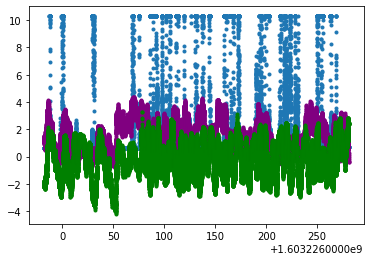

In [62]:
# plt.plot(master_time, interp_odor, '.')
# plt.plot(master_time, interp_wind_U, '.', color='purple')
# plt.plot(master_time, interp_wind_V, '.', color='green')

### New Interpolated Dataframe

In [86]:
new_df = pd.DataFrame({'master_time': master_time,
                            'odor': interp_odor,
                            'trisonica_U': interp_wind_U,
                            'trisonica_V': interp_wind_V,
                            'lat': interp_gps_lat,
                            'lon': interp_gps_lon,
                            'trisonica_pressure':interp_wind_p,
                            'trisonica_temperature':interp_wind_t,
                            'imu_angular_x': interp_imu_x,
                            'imu_angular_y': interp_imu_y,
                            'imu_angular_z': interp_imu_z,
                            'imu_linear_acc_x':interp_imu_linear_acc_x,
                            'imu_linear_acc_y':interp_imu_linear_acc_y,
                            'imu_linear_acc_z':interp_imu_linear_acc_z})

In [88]:
new_df.to_hdf(dir+'odor0'+str(set_number)+'Run03_Interpolated.hdf', key='windn', mode='w')

### Saving Interpolated Bag

In [27]:
new_df.to_hdf(dir+exter_save, key='new_df', mode='w')

In [28]:
dfi= pd.read_hdf(dir+exter_save)

In [29]:
time= dfi.master_time-dfi.master_time[0]
dfi.insert(1,'sync_time',time) 

In [30]:
font = {'size'   : 15}
plt.rc('font', **font)


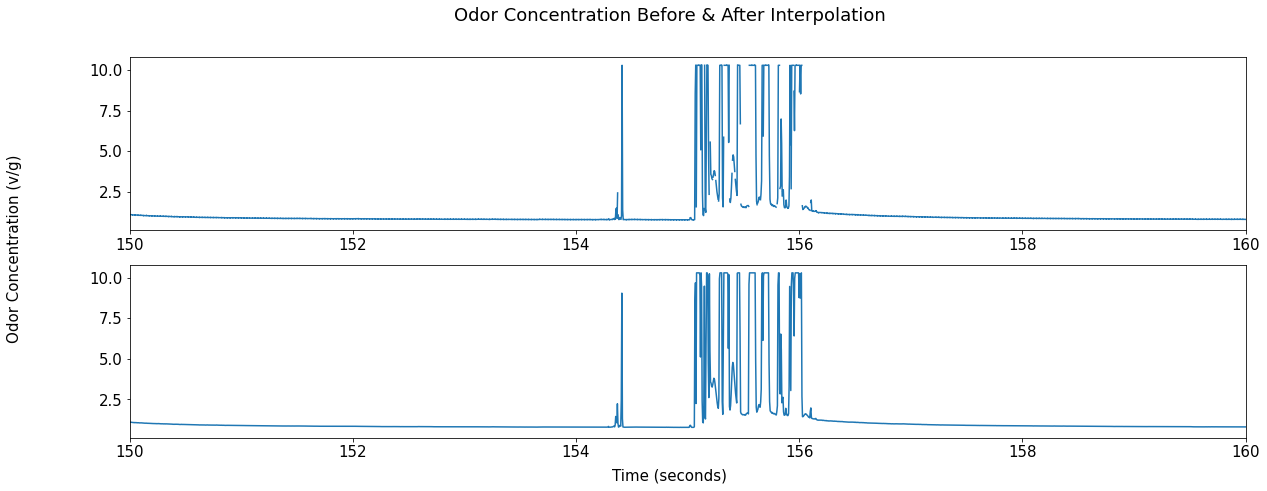

In [31]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(20,7))

f.suptitle('Odor Concentration Before & After Interpolation')
ax1.plot(df.sync_time,df._analog_output_data)
#ax1.set_xlabel('Time (seconds)')
#ax1.set_ylabel('Odor Concentration (v/g)')
ax1.set_xlim(150,160)

ax2.plot(dfi.sync_time,dfi.odor)
ax2.set_xlim(150,160)
#ax2.set_xlabel('Time (seconds)')
#ax2.set_ylabel('Odor Concentration (v/g)')
#plt.xlabel('Time (seconds)')
#plt.ylabel('Odor Concentration (v/g)')
f.text(0.5, 0.04, 'Time (seconds)', ha='center')
f.text(0.04, 0.5, 'Odor Concentration (v/g)', va='center', rotation='vertical')
dir = '../../../Research/Images/recurringplots/'
#f.savefig('../../../figure/odor_b&a_interp.jpg')
#f.tight_layout()